In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Analysis

In [2]:
movie_directors = pd.read_csv('data/processed/movies_director.csv')

In [3]:
movie_directors.head()

,wikipedia_movie_id,Director,Gender
0,975900,John Carpenter,M
1,9363483,Donald Cammell,M
2,261236,Robert van Ackeren,M
3,10408933,Henry King,M
4,175026,Dorothy Arzner,F


In [4]:
# distribution of genders amongst movie directors
fig = px.histogram(movie_directors, x='Gender', title='Gender distribution of movies director')
fig.show()

# Analysis with characters

## Splitting the movie ids: male / female real

In [88]:
movie_directors["wikipedia_movie_id"] = movie_directors["wikipedia_movie_id"].apply(lambda x: str(x))
movies_M = movie_directors[movie_directors["Gender"].apply(lambda x: x=="M")]
movies_F = movie_directors[movie_directors["Gender"].apply(lambda x: x=="F")]

## Actors age

In [7]:
# load characters metadata
char_metadata_df = pd.read_csv("data/processed/characters_metadata.csv")
char_metadata_df["wikipedia_movie_id"] = char_metadata_df["wikipedia_movie_id"].apply(lambda x: str(x))

Splitting the char_metadata_df between the gender of the realisator. First, removing duplicates on actor_names to get actor data and not character.
Check for duplicates: char_metadata_df.where(char_metadata_df.duplicated(subset=["wikipedia_movie_id", "actor_name"]) == True).value_counts()

In [8]:
actors_age = char_metadata_df.copy(deep=True)
actors_age = actors_age.drop_duplicates(subset=["wikipedia_movie_id", "actor_name"])
actors_age["actor_gender_binary"] = actors_age["actor_gender"].apply(lambda x: 0 if x == "M" else 1)

At this step, we complete the age missing values by computing the difference between date of birth and release date.

In [9]:
def to_datetime(df, column):
    # filtering of data for panda.dataframe compliances
    df[column] = df[column].astype(str)

    df = df[(
    df[column] > '1850-01-01') & (df[column] < '2022-01-01'
    )]
    # handling the nan case
    df[column] = df[column].fillna('1850-01-01')
    # keeping only year
    df[column] = pd.to_datetime(df[column], errors="coerce") # need to remove format="mixed" so it works!

    # df = df[df[column].notna()]
    df[column] = df[column].dt.year
    # converting to int
    df[column] = df[column].apply(lambda x: int(x) if pd.notna(x) else x)

    return df

In [10]:
actors_age = to_datetime(actors_age, "actor_date_of_birth")
actors_age.loc[actors_age["actor_age"].isna(), "actor_age"] = (
    (actors_age["movie_release_date"] - actors_age["actor_date_of_birth"])
)

In [73]:
actors_age_M = actors_age[actors_age["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])].reset_index(drop=True)
actors_age_F = actors_age[actors_age["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])].reset_index(drop=True)

In [12]:
def plot_age_distribution(actors_age, gender_real:str):

    actors_age_gender = actors_age.groupby("actor_age")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()
    actors_age_gender["Tot_actors"] = actors_age_gender[0] + actors_age_gender[1]
    actors_age_gender = actors_age_gender[actors_age_gender["Tot_actors"] >= 200]

    # Calculate weighted average age for each gender
    avg_age_male = (actors_age_gender['actor_age'] * actors_age_gender[0]).sum() / actors_age_gender[0].sum()
    avg_age_female = (actors_age_gender['actor_age'] * actors_age_gender[1]).sum() / actors_age_gender[1].sum()

    male_trace = go.Scatter(
        x=actors_age_gender['actor_age'],
        y=actors_age_gender[0],
        mode="lines+markers",
        name="Male actors",
        line=dict()
    )
    female_trace = go.Scatter(
        x=actors_age_gender['actor_age'],
        y=actors_age_gender[1],
        mode="lines+markers",
        name="Female actors",
        line=dict()
    )


    # Create traces for the average age lines
    avg_male_line = go.Scatter(
        x=[avg_age_male, avg_age_male],
        y=[0, actors_age_gender[[0, 1]].values.max()],
        mode="lines",
        line=dict(color="red", dash="dash"),
        name=f"Avg Male Age: {avg_age_male:.0f}"
    )
    avg_female_line = go.Scatter(
        x=[avg_age_female, avg_age_female],
        y=[0, actors_age_gender[[0, 1]].values.max()],
        mode="lines",
        line=dict(color="red"),
        name=f"Avg Female Age: {avg_age_female:.0f}"
    )

    # Create the figure
    fig = go.Figure(data=[male_trace, female_trace, avg_male_line, avg_female_line])

    # Update layout
    fig.update_layout(
        title=f"Number of Characters by Age - {gender_real} Filmmaker",
        xaxis_title="Age",
        yaxis_title="Number of Actors",
        barmode="stack",
        legend_title="Legend",
        template="plotly_white"
    )


    # Show the plot
    fig.show()


In [13]:
plot_age_distribution(actors_age_M, "Male")

In [14]:
plot_age_distribution(actors_age_F, "Female")

**Discussion:** Do a percentage, both on the same

## Number of actors distribution

In [20]:
# First, filter and start years in 1930
actors_age_M = actors_age_M[actors_age_M["movie_release_date"] >= 1930]
actors_age_F = actors_age_F[actors_age_F["movie_release_date"] >= 1930]

# Group by movie release date and calculate the mean proportion of female characters
characters_gender_time_M = actors_age_M.groupby("movie_release_date")["actor_gender_binary"].agg(['mean', 'count']).reset_index()
characters_gender_time_F = actors_age_F.groupby("movie_release_date")["actor_gender_binary"].agg(['mean', 'count']).reset_index()

# Total number of movies
num_movies_M = actors_age_M.groupby("movie_release_date")["wikipedia_movie_id"].nunique().values
num_movies_F = actors_age_F.groupby("movie_release_date")["wikipedia_movie_id"].nunique().values

# Create the plot with Plotly
fig = go.Figure()

# Female representation for male-directed movies
fig.add_trace(go.Scatter(
    x=characters_gender_time_M["movie_release_date"],
    y=np.array(characters_gender_time_M["mean"]) * 100,  # Convert to percentage
    name="Male Directors",
    mode="lines",
    customdata=np.stack((characters_gender_time_M['count'], num_movies_M), axis=-1),
    hovertemplate=(
        "Year: %{x}<br>"
        "Proportion of Female Characters: %{y:.2f}<br><br>"
        "Total Number of Characters: %{customdata[0]}<br>"
        "Number of Movies: %{customdata[1]}"
    ),
))

# Female representation for female-directed movies
fig.add_trace(go.Scatter(
    x=characters_gender_time_F["movie_release_date"],
    y=np.array(characters_gender_time_F["mean"]) * 100,  # Convert to percentage
    name="Female Directors",
    mode="lines",
    customdata=np.stack((characters_gender_time_F['count'], num_movies_F), axis=-1),
    hovertemplate=(
        "Year: %{x}<br>"
        "Proportion of Female Characters: %{y:.2f}<br><br>"
        "Total Number of Characters: %{customdata[0]}<br>"
        "Number of Movies: %{customdata[1]}"
    ),
))

# Customize the layout
fig.update_layout(
    title="Representation of Female Characters by Director Gender",
    yaxis_title="Percentage of Female Characters in Movies [%]",
    xaxis=dict(
        tickmode='array',
        tickvals=characters_gender_time_M["movie_release_date"][::5],  # Display ticks every 5 years
        ticktext=characters_gender_time_M["movie_release_date"][::5]
    ),
    yaxis=dict(
        tickformat=".0f",  # This formats the y-axis ticks as whole percentages
    ),
    legend_title="Director Gender",
    width=1150,
    height=700,
    template="plotly_white"  # Use a white background
)

fig.show()


## Characters and movie metadata

In [82]:
movies_metadata_df = pd.read_csv("data/processed/movies_metadata_new.csv")
movies_metadata_df["wikipedia_movie_id"] = movies_metadata_df["wikipedia_movie_id"].apply(lambda x: str(x))
movies_metadata_df = movies_metadata_df[movies_metadata_df["wikipedia_movie_id"].isin(correct_movies)].reset_index(drop=True)

In [83]:
import ast

movies_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_df = movies_df[["wikipedia_movie_id", "movie_release_date", "movie_genres", "movie_countries"]]
# groupby to make a list that contains all genders for a given movie
genders_grouped = (
    char_metadata_df.groupby("wikipedia_movie_id")["actor_gender"]
    .apply(list)  # Collect genders into lists
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={"actor_gender": "actor_genders"})  # Rename the column
)
# merging
movies_df = movies_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_df['movie_genres'] = movies_df['movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
movies_df['movie_countries'] = movies_df['movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

movies_df


,wikipedia_movie_id,movie_release_date,movie_genres,movie_countries,actor_genders
0,3196793,2000,"[Horror, Biographical and Real-Life Inspired, ...",[United States],"[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]"
1,28463795,1988,"[Crime and Mystery, Drama]",[Norway],"[M, F, M, F]"
2,9363483,1987,[Thriller],[United Kingdom],"[M, F]"
3,261236,1983,[Drama],[Germany],"[F, M, M]"
4,18998739,2002,"[Family's Films, Fantasy, Adventure, World Cin...",[South Africa],"[M, F, M, M, M, M, M, M]"
...,...,...,...,...,...
73865,35228177,2011,[Drama],[United States],NaN
73866,34980460,2011,"[Biographical and Real-Life Inspired, Drama, D...","[Ireland, United Kingdom]",NaN
73867,9971909,1972,[Comedy],[United States],"[M, M]"
73868,913762,1992,"[Science Fiction, World Cinema, Adventure, Ani...",[Japan],"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]"


In [23]:
import plotly.graph_objects as go

def plot_top10_genres(movies_df, gender_real):
    genre_gender_counts = movies_df.explode("actor_genders").explode("movie_genres")
    gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)
    gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100
    genre_counts = genre_gender_counts.groupby('movie_genres').size().sort_values(ascending=False).head(10)
    gender_genre_counts_top10 = gender_genre_counts.loc[genre_counts.index]
    gender_genre_percentages_top10 = gender_genre_percentages.loc[genre_counts.index]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=gender_genre_percentages_top10.index,
        y=gender_genre_percentages_top10['F'],
        name="Female",
        marker_color="#EF553B",
    ))
    fig.add_trace(go.Bar(
        x=gender_genre_percentages_top10.index,
        y=gender_genre_percentages_top10['M'],
        name="Male",
        marker_color="#636EFA"
    ))

    fig.update_layout(
        title=f"Gender Representation Across Top-10 Movie Genres - {gender_real} Filmmaker",
        xaxis_title="Movie Genre",
        yaxis_title="Percentage of Characters (%)",
        barmode='stack',
        xaxis=dict(
            tickmode='array',
            tickvals=gender_genre_percentages_top10.index,
            ticktext=gender_genre_percentages_top10.index,
            tickangle=45
        ),
        height=600,
        legend_title="Gender",
        legend=dict(title="Gender", orientation="h", x=0.5, xanchor="center", y=1.1)
    )
    fig.show()

def plot_top15_genres(movies_df, gender_real):
    genre_gender_counts = movies_df.explode("actor_genders").explode("movie_genres")
    gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)
    gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100
    top_10_genres_female_percentage = gender_genre_percentages["F"].sort_values(ascending=False).head(15)

    fig2 = go.Figure()
    fig2.add_trace(go.Bar(
        x=top_10_genres_female_percentage.index,
        y=top_10_genres_female_percentage,
        name="Female",
        marker_color="#EF553B",
    ))

    fig2.update_layout(
        title=f"Top-15 Genres with Highest Percentage of Female Characters - {gender_real} Filmmaker",
        xaxis_title="Movie Genre",
        yaxis_title="Percentage of Female Characters (%)",
        xaxis=dict(
            tickmode='array',
            tickvals=top_10_genres_female_percentage.index,
            ticktext=top_10_genres_female_percentage.index,
            tickangle=45
        ),
        height=600
    )
    fig2.show()


In [24]:
movies_genres_M = movies_df[movies_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])]
movies_genres_F = movies_df[movies_df["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])]

In [25]:
plot_top10_genres(movies_genres_M, "Male")
plot_top10_genres(movies_genres_F, "Female")

**Discussion:** Add the total number of movies

In [26]:
plot_top15_genres(movies_genres_M, "Male")
plot_top15_genres(movies_genres_F, "Female")

# Race chart of genres

In [163]:
# Step 1: Filter movies for male directors
movies_genres_M = movies_df[movies_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])][["wikipedia_movie_id", "movie_release_date", "movie_genres"]]

# Step 2: Consider movies released from 1930 onward
movies_genres_M = movies_genres_M[movies_genres_M["movie_release_date"] >= 1930]

# Step 3: Explode the 'movie_genres' column to create one row per genre
movies_genres_M = movies_genres_M.explode("movie_genres")

# Step 4: Count the total occurrences of each genre across all years
global_genre_counts = movies_genres_M['movie_genres'].value_counts()

# Step 5: Identify the global top-8 genres
global_top_8_genres = global_genre_counts.head(8).index.tolist()

# Step 6: Filter the dataset to include only the global top-8 genres
movies_genres_top_8 = movies_genres_M[movies_genres_M["movie_genres"].isin(global_top_8_genres)]

# Step 7: Group by year and genre, count the occurrences
movies_genres_top_8_year = movies_genres_top_8.groupby(['movie_release_date', 'movie_genres']).size().reset_index(name='count')

# Step 8: Add the rank for each genre within each year
movies_genres_top_8_year['rank'] = (
    movies_genres_top_8_year.groupby('movie_release_date')['count']
    .rank(ascending=False, method='first')  # Resolve ties by order of appearance
    .astype(int) - 1  # Convert ranks to 0-based
)

# # Step 9: Normalize rankings to ensure they are 0 to 7
# movies_genres_top_8_year['rank'] = (
#     movies_genres_top_8_year.groupby('movie_release_date')['rank']
#     .transform(lambda x: pd.Series(range(len(x))))
# )

# Step 10: Sort by year and rank
movies_genres_top_8_year = movies_genres_top_8_year.sort_values(['movie_release_date', 'rank']).reset_index(drop=True)

# Display the resulting DataFrame
movies_genres_top_8_year


,movie_release_date,movie_genres,count,rank
0,1930,Comedy,78,0
1,1930,Drama,70,1
2,1930,Romance,46,2
3,1930,Action,17,3
4,1930,Adventure,15,4
...,...,...,...,...
659,2012,Action,73,3
660,2012,Romance,70,4
661,2012,Horror,60,5
662,2012,Adventure,34,6


In [164]:
import json

# Format the data as specified
formatted_data = movies_genres_top_8_year.groupby('movie_release_date').apply(
    lambda group: [
        {
            "name": row["movie_genres"],
            "value": row["count"],
            "rank": row["rank"]
        } for _, row in group.iterrows()
    ]
).reset_index(name="genres").apply(
    lambda row: [row['movie_release_date'], row['genres']], axis=1
).tolist()

# Save the formatted data to a JSON file
output_path = "top_genres_by_year.json"
with open(output_path, "w") as f:
    json.dump(formatted_data, f, indent=4)

output_path


'top_genres_by_year.json'

In [157]:
print(movies_genres_top_8.columns)


Index(['wikipedia_movie_id', 'movie_release_date', 'movie_genres'], dtype='object')


# Keep going for the race chart! --> female !

# Bubble charts of genres with female characters

In [72]:
# Filter movies for male directors
movies_genres_M = movies_df[movies_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])][["wikipedia_movie_id", "movie_release_date", "movie_genres", "actor_genders"]]

# Prepare the movies dataset
movies_genres_female = movies_genres_M.explode("movie_genres").explode("actor_genders")

# Filter for movies with at least one female character and count occurrences
genre_gender_counts = movies_genres_female.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)

# Total characters per genre
genre_gender_counts["Total Characters"] = genre_gender_counts.sum(axis=1)

# Female percentage calculation
genre_gender_counts["Female Percentage"] = (genre_gender_counts["F"] / genre_gender_counts["Total Characters"]) * 100

# Total movies in each genre
genre_movie_counts = movies_genres_female.groupby("movie_genres")["wikipedia_movie_id"].nunique()

# Combine into a single dataframe
genre_stats_df = pd.DataFrame({
    "Genre": genre_gender_counts.index,
    "Female Percentage": genre_gender_counts["Female Percentage"],
    "Total Characters": genre_gender_counts["Total Characters"],
    "Total Movies": genre_movie_counts
}).reset_index(drop=True)

# Filter for the top-10 genres by Female Percentage
top_10_genres_df = genre_stats_df.sort_values("Female Percentage", ascending=False).head(10)
top_10_genres_df


,Genre,Female Percentage,Total Characters,Total Movies
25,Health & Fitness,70.000000,10,3
33,Mondo film,61.904762,21,4
22,Feminist,53.728489,523,52
18,Erotic and Adult Films,45.526194,2157,292
14,Coming-of-age film,44.680851,47,4
42,Roadshow/Carny,44.444444,27,3
47,Slice of life story,41.621622,740,62
43,Romance,38.848455,52486,5712
21,Female buddy film,38.297872,47,4
37,Other Genres,37.024087,2574,314


In [65]:
import json

# Load the JSON file containing the genre hierarchy
with open("data/raw/clusters.json", "r") as file:
    genre_hierarchy = json.load(file)

# Top-10 genres (parent categories) found earlier
top_10_genres = top_10_genres_df["Genre"].tolist()

# Extract the children for each top-10 genre
top_10_with_children = {parent: genre_hierarchy["Genres"].get(parent, []) for parent in top_10_genres}

# Prepare hierarchical data for LayerChart
layer_chart_data = {
    "data": {"name": "flare"},  # Root node
    "height": 4,  # Total hierarchy depth
    "depth": 0,
    "parent": None,
    "children": []  # Populate children for top-10 genres
}

# Populate the first layer (top-10 genres with their stats and children)
for _, row in top_10_genres_df.iterrows():
    genre_name = row["Genre"]
    children = top_10_with_children.get(genre_name, [])  # Get actual children from the JSON

    # Parent node
    genre_data = {
        "data": {
            "name": genre_name,
            "Female Percentage": row["Female Percentage"],
            "Total Characters": row["Total Characters"],
            "Total Movies": row["Total Movies"]
        },
        "height": 3,  # Depth for this layer
        "depth": 1,
        "parent": "flare",  # Root parent
        "children": []  # Placeholder for actual children
    }

    # Populate children nodes
    for child in children:
        child_data = {
            "data": {"name": child},
            "height": 2,
            "depth": 2,
            "parent": genre_name,
            "children": []
        }
        genre_data["children"].append(child_data)
    
    # Add to root's children
    layer_chart_data["children"].append(genre_data)

# Final LayerChart-compatible hierarchical data
print(json.dumps(layer_chart_data, indent=4))

# Save as a JSON file for LayerChart
with open("female_characters_bubbles.json", "w") as f:
    json.dump(layer_chart_data, f, indent=4)


{
    "data": {
        "name": "flare"
    },
    "height": 4,
    "depth": 0,
    "parent": null,
    "children": [
        {
            "data": {
                "name": "Health & Fitness",
                "Female Percentage": 70.0,
                "Total Characters": 10,
                "Total Movies": 3
            },
            "height": 3,
            "depth": 1,
            "parent": "flare",
            "children": []
        },
        {
            "data": {
                "name": "Mondo film",
                "Female Percentage": 61.904761904761905,
                "Total Characters": 21,
                "Total Movies": 4
            },
            "height": 3,
            "depth": 1,
            "parent": "flare",
            "children": []
        },
        {
            "data": {
                "name": "Feminist",
                "Female Percentage": 50.697674418604656,
                "Total Characters": 430,
                "Total Movies": 43
            },
      

In [ ]:
# Prepare hierarchical data
layer_chart_data = {
    "data": {"name": "flare"},  # Root node
    "height": 4,  # Total hierarchy depth
    "depth": 0,
    "parent": None,
    "children": []  # Populate children for top-10 genres
}

# Iterate over the top-10 genres to create the first layer
for _, row in top_10_genres_df.iterrows():
    genre_name = row["Genre"]
    genre_data = {
        "data": {
            "name": genre_name,
            "Female Percentage": row["Female Percentage"],
            "Total Characters": row["Total Characters"],
            "Total Movies": row["Total Movies"]
        },
        "height": 3,  # Depth for this layer
        "depth": 1,
        "parent": "flare",  # Root parent
        "children": []  # Placeholder for sub-genres
    }

    # Add dummy children for now
    for i in range(7):  # Assume 7 children per genre
        child_data = {
            "data": {"name": f"{genre_name} Child {i+1}"},
            "height": 2,
            "depth": 2,
            "parent": genre_name,
            "children": []
        }
        genre_data["children"].append(child_data)
    
    layer_chart_data["children"].append(genre_data)

# Final LayerChart-compatible hierarchical data
layer_chart_data


# By countries

In [25]:
import plotly.graph_objects as go

def plot_genre_country_gender_representation(movies_genres_country_df, gender_real=""):
    genre_country_gender_counts = movies_genres_country_df.explode("actor_genders").explode("movie_genres").explode("movie_countries")

    genre_country_gender_counts = genre_country_gender_counts.groupby(['movie_genres', 'movie_countries', 'actor_genders']).size().unstack(fill_value=0)

    gender_percentage = genre_country_gender_counts['F'] / genre_country_gender_counts.sum(axis=1) * 100

    total_actors = genre_country_gender_counts.sum(axis=1)

    countries = sorted(genre_country_gender_counts.groupby('movie_countries').size().sort_values(ascending=False).head(10).index)
    
    gender_percentage_top_10_countries = gender_percentage[gender_percentage.index.get_level_values('movie_countries').isin(countries)]
    gender_percentage_top_10_countries = gender_percentage_top_10_countries[gender_percentage_top_10_countries >= 40]

    genre_country_gender_counts_top_10_countries = genre_country_gender_counts.loc[gender_percentage_top_10_countries.index]

    bubble_size = total_actors.loc[gender_percentage_top_10_countries.index] * 0.1  # Adjust this factor to reduce bubble size

    # Ensure the bubble sizes are within a reasonable range
    max_bubble_size = bubble_size.max()
    min_bubble_size = bubble_size.min()
    bubble_size = (bubble_size - min_bubble_size) / (max_bubble_size - min_bubble_size) * 150  # Scale the bubble size to a max value of 40

    genres = sorted(genre_country_gender_counts.index.get_level_values('movie_genres').unique())

    genre_indices = [genres.index(genre) for genre in gender_percentage_top_10_countries.index.get_level_values('movie_genres')]
    country_indices = [countries.index(country) for country in gender_percentage_top_10_countries.index.get_level_values('movie_countries')]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=genre_indices,
        y=country_indices,
        mode='markers',
        marker=dict(
            size=bubble_size,
            color=gender_percentage.loc[gender_percentage_top_10_countries.index],
            # colorscale='PuRd',
            showscale=True,
            opacity=0.6,
            line=dict(width=1, color='white')
        ),
        text=gender_percentage_top_10_countries.index.get_level_values('movie_genres') + " - " + gender_percentage_top_10_countries.index.get_level_values('movie_countries'),
        hovertemplate='%{text}<br>Female Percentage: %{marker.color:.2f}%<br>Total Actors: %{marker.size}<extra></extra>'
    ))

    fig.update_layout(
        title=f"Gender Representation Across Movie Genres and Top-10 Countries - {gender_real} Filmmaker",
        xaxis_title="Movie Genre",
        yaxis_title="Country",
        xaxis=dict(
            tickvals=list(range(len(genres))),
            ticktext=genres,
            tickangle=45
        ),
        yaxis=dict(
            tickvals=list(range(len(countries))),
            ticktext=countries
        ),
        showlegend=False,
        height=600
    )

    fig.show()


In [123]:
plot_genre_country_gender_representation(movies_genres_M, "Male")

In [124]:
plot_genre_country_gender_representation(movies_genres_F, "Female")

**Discussion:** Reduce scale on the right, create a map

## With TV tropes

In [126]:
from src.data.data_loader import load_csv
tvtropes_df = load_csv('data/raw/' + 'tvtropes.clusters.txt', has_column_names=False, is_tsv=True, column_names=['character_type', 'metadata'])

Loaded data from data/raw/tvtropes.clusters.txt, shape: (500, 2)


In [127]:
tvtropes_df['metadata'] = tvtropes_df['metadata'].apply(ast.literal_eval)
tvtropes_df = pd.concat([tvtropes_df.drop(['metadata'], axis=1), tvtropes_df['metadata'].apply(pd.Series)], axis=1)
tvtropes_df = tvtropes_df.rename(columns={'char': 'char_name', 'actor': 'actor_name', 'movie': 'movie_name', 'id': 'char_actor_id'})
# We add the character information and especially its gender
tvtropes_df['actor_gender'] = tvtropes_df['actor_name'].map(char_metadata_df.set_index('actor_name')['actor_gender'].to_dict())

tvtropes_df.head()

,character_type,char_name,movie_name,char_actor_id,actor_name,actor_gender
0,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M
1,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M
2,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M
3,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,M


In [137]:
# Complete tvtropes to get the movie ID, using the name of the movie and the char_actor_id, to get movie genres and countries
# we first need to add the movie_name column in the char_metadata_df
char_movie_df = pd.merge(
    actors_age,
    movies_df[['wikipedia_movie_id', "movie_countries", "movie_genres"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['wikipedia_movie_id']  # Merge on char_id and movie_name
)
# now we can complete tvtropes
tvtropes_completed_df = pd.merge(
    tvtropes_df,
    char_movie_df[['char_actor_id', 'wikipedia_movie_id', "movie_countries", "movie_genres", "movie_release_date"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['char_actor_id']  # Merge on char_id and movie_name
)

In [178]:
import plotly.graph_objects as go

def plot_gender_tvtropes(tvtropes_completed_df, gender_real):
    # Group by character type and actor gender
    character_type_gender_counts = tvtropes_completed_df.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
    filtered_character_type_gender_counts = character_type_gender_counts[character_type_gender_counts['F'] >= 0]

    # Create the plot with Plotly
    fig = go.Figure()

    # Plot Female data (stacked bar)
    fig.add_trace(go.Bar(
        x=filtered_character_type_gender_counts.index,
        y=filtered_character_type_gender_counts['F'],
        name='Female',
        marker_color="rgba(255, 99, 132, 0.7)",  # Soft red
        text=filtered_character_type_gender_counts['F'],
        hovertemplate='Character Type: %{x}<br>Female Actors: %{y}<extra></extra>',
    ))

    # Plot Male data (stacked bar)
    fig.add_trace(go.Bar(
        x=filtered_character_type_gender_counts.index,
        y=filtered_character_type_gender_counts['M'],
        name='Male',
        marker_color="rgba(54, 162, 235, 0.7)",  # Soft blue
        text=filtered_character_type_gender_counts['M'],
        hovertemplate='Character Type: %{x}<br>Male Actors: %{y}<extra></extra>',
    ))

    # Update layout for overall aesthetics
    fig.update_layout(
        title=f"Gender Representation Across Character Types - {gender_real} Filmmaker",
        xaxis_title="Character Type",
        yaxis_title="Number of Actors",
        barmode='stack',  # Stack the bars for gender representation
        showlegend=True,
        height=600,  # Adjust the plot height for better readability
        xaxis=dict(
            tickangle=45,  # Rotate tick labels to make them readable
            tickfont=dict(size=10),  # Adjust font size of x-ticks
            tickmode='array',
            tickvals=filtered_character_type_gender_counts.index,
            ticktext=filtered_character_type_gender_counts.index,
        ),
        yaxis=dict(
            title="Number of Actors",
            tickfont=dict(size=12),  # Adjust font size of y-ticks
        ),
        legend_title="Gender",
        legend=dict(
            orientation="v",  # Vertical legend for space efficiency
            yanchor="top", 
            y=1,  # Position at the top of the plot
            xanchor="right", 
            x=1,  # Align to the right
        ),
        margin=dict(t=50, b=100, l=50, r=50),  # Adjust margins for better spacing
        template="plotly_white"  # Use white background for the plot
    )

    fig.show()


In [179]:
tvtropes_M = tvtropes_completed_df[tvtropes_completed_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])]
tvtropes_F = tvtropes_completed_df[tvtropes_completed_df["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])]

In [180]:
plot_gender_tvtropes(tvtropes_M, "Male")

In [181]:
plot_gender_tvtropes(tvtropes_F, "Female")

**Discussion:** Go check the tv-tropes.

# Bechdel Test

In [438]:
bechdel_df = pd.read_csv('data/processed/bechdel_ratings.csv')
bechdel_df["wikipedia_movie_id"] = bechdel_df["wikipedia_movie_id"].apply(lambda x: str(x))

In [439]:
# Number from 0 to 3 (0 means no two women, 1 means no talking, 2 means talking about a man, 3 means it passes the test).
bechdel_dict = {
    '0': 'no two women',
    '1': 'no talking',
    '2': 'talking about a man',
    '3': 'passes the test'
}

### Data augmentation

In [440]:
bechdel_df = pd.merge(
    bechdel_df,
    movies_df[['wikipedia_movie_id', "movie_genres", "movie_countries", "actor_genders"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)

### Differentiating between directors

In [441]:
bechdel_M = bechdel_df[bechdel_df['wikipedia_movie_id'].isin(movies_M['wikipedia_movie_id'])]
bechdel_F = bechdel_df[bechdel_df['wikipedia_movie_id'].isin(movies_F['wikipedia_movie_id'])]

In [442]:
bechdel_M.shape, bechdel_F.shape

((3268, 7), (365, 7))

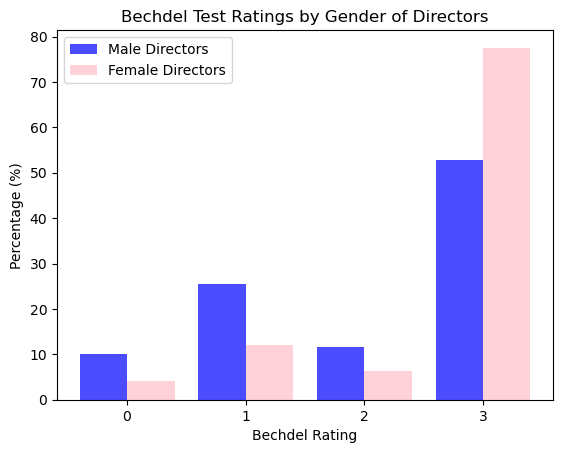

In [443]:
bechdel_M_hist = (bechdel_M["bechdel_rating"].value_counts()/bechdel_M.shape[0] * 100).values
bechdel_F_hist = (bechdel_F["bechdel_rating"].value_counts()/bechdel_F.shape[0] * 100).values

# Get x positions (ensure the indices align properly)
x = np.array((bechdel_M["bechdel_rating"].value_counts().index))
bar_width = 0.4  # Width of the bars

# Plot bars
plt.bar(x - bar_width / 2, bechdel_M_hist, width=bar_width, label="Male Directors", color="blue", alpha=0.7)
plt.bar(x + bar_width / 2, bechdel_F_hist, width=bar_width, label="Female Directors", color="pink", alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Bechdel Rating")
plt.ylabel("Percentage (%)")
plt.title("Bechdel Test Ratings by Gender of Directors")
plt.xticks(x)  # Set the x-axis ticks to the Bechdel rating
plt.legend()

## Preprocessing data for ML

In [444]:
# adding director_gender column
bechdel_df["director_gender"] = bechdel_df["wikipedia_movie_id"].apply(
    lambda x: 0 if x in movies_M['wikipedia_movie_id'].values else 
              (1 if x in movies_F['wikipedia_movie_id'].values else np.nan)
)
bechdel_df = bechdel_df.dropna(subset="director_gender")

In [457]:
bechdel_ML = bechdel_df.copy(deep=True)
# take care of genres and countries and actor_genders columns
# get all genres and countries
genres_list = bechdel_ML.explode("movie_genres")["movie_genres"].unique().tolist()
countries_list = bechdel_ML.explode("movie_countries")["movie_countries"].unique().tolist()
# add genre and countries columns
cols_df = pd.DataFrame(columns=["char_M", "char_F"] + genres_list + countries_list)
bechdel_ML = pd.concat([bechdel_df, cols_df], axis=1).fillna(0).reset_index(drop=True)

for index, row in bechdel_ML.iterrows():
    genres = row["movie_genres"]
    countries = row["movie_countries"]
    genders = row["actor_genders"]
    for genre in genres:
        bechdel_ML.at[index, genre] = 1
    for country in countries:
        bechdel_ML.at[index, country] = 1
    for gender in genders:
        if gender == "M":
            bechdel_ML.at[index, "char_M"] += 1
        else:
            bechdel_ML.at[index, "char_F"] += 1

# dropping columns
bechdel_ML = bechdel_ML.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "wikipedia_movie_id", "movie_name"])
bechdel_ML.columns = bechdel_ML.columns.astype(str)

# simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
bechdel_ML["bechdel_rating"] = bechdel_ML["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

In [389]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [459]:
# we prepare the data
target_cols = ["bechdel_rating"]
features_cols = bechdel_ML.keys().tolist()
features_cols.remove(target_cols[0])
X = bechdel_ML[features_cols]
y = bechdel_ML[target_cols]

# we split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we squeeze to match the dimensions
y_test = y_test.squeeze()
y_train = y_train.squeeze()

# Load the module
scaler = StandardScaler()

# Standardize X train
scaler.fit(X_train) # used both for X_train and X_test
X_train_standardized = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

# Standardize X test using mean and std from training set
X_test_standardized = scaler.transform(X_test)

## Training

In [476]:
# training tree
# rf = RandomForestClassifier(random_state=42, n_estimators=2)
rf = DecisionTreeClassifier(random_state=42, max_depth=4)

rf.fit(X_train_standardized, y_train)
y_pred_test = rf.predict(X_test_standardized)
y_pred_train = rf.predict(X_train_standardized)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train)}')

The accuracy score for test set is: 0.686382393397524
The accuracy score for train set is: 0.7164487267721955


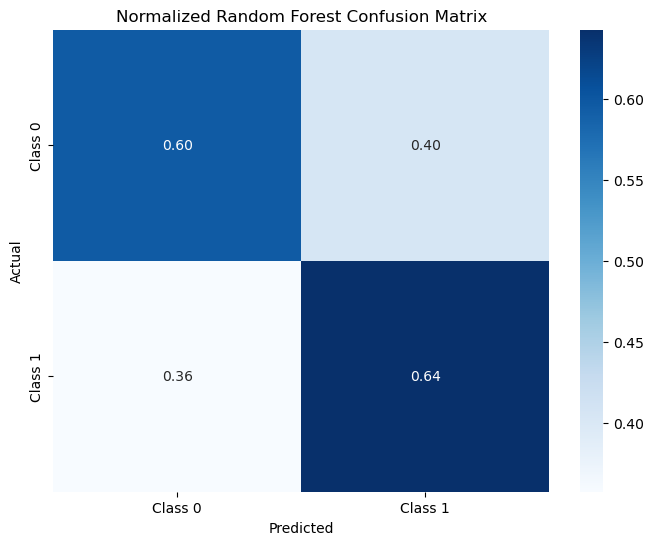

In [477]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to get proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [468]:
# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Get the feature names (assuming you have the feature names stored in a variable like 'X_train.columns')
feature_names = X_train.columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
feature_importance_df.head(30)


,Feature,Importance
3,char_F,0.558059
2,char_M,0.328468
0,movie_release_date,0.033518
13,Romance,0.013000
10,Fantasy,0.012914
11,Comedy,0.011918
6,Adventure,0.008402
18,Action,0.006831
26,Crime and Mystery,0.006826
39,Pre-Code,0.004910


## Logistic regression

In [469]:
log_reg_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model
log_reg_model.fit(X_train_standardized, y_train)

y_pred_test = log_reg_model.predict(X_test_standardized)
y_pred_train = log_reg_model.predict(X_train_standardized)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train)}')


The accuracy score for test set is: 0.6616231086657497
The accuracy score for train set is: 0.7339986235375086


## Removing unimportant features

In [470]:
# Get feature importances (this assumes you've trained a Random Forest model)
feature_importances = rf.feature_importances_

# Identify features with zero importance
zero_importance_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance == 0]

# Remove features with zero importance
X_train_reduced = X_train.drop(columns=zero_importance_features)
X_test_reduced = X_test.drop(columns=zero_importance_features)

scaler.fit(X_train_reduced) # used both for X_train and X_test
X_train_standardized = scaler.transform(X_train_reduced)
X_test_standardized = scaler.transform(X_test_reduced)

# Retrain the model with reduced features
model_rf_reduced = DecisionTreeClassifier(random_state=42)
model_rf_reduced.fit(X_train_reduced, y_train)

# Check performance again
y_pred_reduced = model_rf_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Accuracy with reduced features: {accuracy_reduced}")


Accuracy with reduced features: 0.6107290233837689


## Keeping only top-6 features

In [471]:
# Get feature importances from the random forest model
importances = rf.feature_importances_

# Get the top 3 most important features: 6 is the best!
top_3_feature_indices = importances.argsort()[-30:][::-1]  # Get indices of top 3 features
top_3_feature_names = [X_train.columns[i] for i in top_3_feature_indices]

# Select the top 3 features
X_train_top3 = X_train[top_3_feature_names]
X_test_top3 = X_test[top_3_feature_names]

scaler.fit(X_train_top3) # used both for X_train and X_test
X_train_top3 = scaler.transform(X_train_top3)
X_test_top3 = scaler.transform(X_test_top3)

# Initialize the decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the top-3 features
dt_model.fit(X_train_top3, y_train)

# Make predictions and evaluate the model
y_pred = dt_model.predict(X_test_top3)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree on Top-3 Features: {accuracy}")


Accuracy of Decision Tree on Top-3 Features: 0.6189821182943603
